# Deep Learning models - Experiments
by Betinna Pölzleitner

this file is an experimental file to try out different Manual model architectures and their effects on our Time series, while the results are satisfactory they are to complicated to be a trusted sources\
-> as such we choose to use NIXTLA

In [2]:
import polars as pl
import numpy as np
import pandas as pd

In [3]:
# Compatibility shim for NumPy future change
import numpy as np
if not hasattr(np, "object"):
    np.object = np.object_  # silence FutureWarning from tf2onnx

C:\Users\cleo7\AppData\Local\Temp\ipykernel_6496\340568335.py:3: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [4]:
fourier_train = pl.read_parquet("../data/processed_data/fourier_train.parquet")
fth_train = pl.read_parquet("../data/processed_data/fourier+trend+holidays_train.parquet")
holidays_train = pl.read_parquet("../data/processed_data/holidays_train.parquet")
trend_train = pl.read_parquet("../data/processed_data/trend_train.parquet")
none_train = pl.read_parquet("../data/processed_data/none_train.parquet")

In [5]:
fourier_test = pl.read_parquet("../data/processed_data/fourier_test.parquet")
fth_test = pl.read_parquet("../data/processed_data/fourier+trend+holidays_test.parquet")
holidays_test = pl.read_parquet("../data/processed_data/holidays_test.parquet")
trend_test = pl.read_parquet("../data/processed_data/trend_test.parquet")
none_test = pl.read_parquet("../data/processed_data/none_test.parquet")

In [6]:
def get_features(df, target_col="y", exclude=None, include=None):
    """Return a list of feature column names from a DataFrame.
    - Works with Polars or pandas DataFrames.
    - Excludes the target column and any names in `exclude`.
    - If `include` is provided, returns only those columns (after exclusion filtering).
    """
    
    # Determine available columns
    try:
        cols = list(df.columns)
    except Exception as _:
        raise TypeError("get_features expects a DataFrame with a 'columns' attribute.")
    
    # If an explicit include list is provided, start from it
    if include is not None:
        base = [c for c in include if c in cols]
    else:
        base = cols
    
    # Build exclusion set (always exclude target_col when provided)
    excl = set()
    if target_col is not None:
        excl.add(target_col)
    if exclude:
        excl.update(exclude)
    
    # Filter and return
    feature_cols = [c for c in base if c not in excl]
    return feature_cols

In [7]:
def scale_data(train_df, test_df, target_col, feature_cols=None):
    # Convert to pandas for sklearn
    train_pd = train_df.to_pandas() if isinstance(train_df, pl.DataFrame) else train_df.copy()
    test_pd = test_df.to_pandas() if isinstance(test_df, pl.DataFrame) else test_df.copy()
    
    # Select features/target
    if feature_cols is None:
        feature_cols = [c for c in train_pd.columns if c != target_col]
    X_train = train_pd[feature_cols].copy()
    y_train = train_pd[target_col].copy()
    X_test = test_pd[feature_cols].copy()
    y_test = test_pd[target_col].copy()
    
    # Combine to ensure identical one-hot columns
    X_train['_split'] = 'train'
    X_test['_split'] = 'test'
    combo = pd.concat([X_train, X_test], axis=0)
    
    # Convert datetimes to numeric seconds since epoch
    for col in combo.columns:
        if col == '_split':
            continue
        if np.issubdtype(combo[col].dtype, np.datetime64):
            combo[col] = pd.to_datetime(combo[col], errors='coerce').astype('int64') / 1e9
    
    # One-hot encode string/object/categorical columns
    cat_cols = [c for c in combo.columns if combo[c].dtype == 'object' and c != '_split']
    if cat_cols:
        combo = pd.get_dummies(combo, columns=cat_cols, drop_first=False)
    
    # Fill any remaining NaNs
    combo = combo.fillna(0)
    
    # Split back
    X_train_enc = combo[combo['_split'] == 'train'].drop(columns=['_split'])
    X_test_enc = combo[combo['_split'] == 'test'].drop(columns=['_split'])
    from sklearn.preprocessing import StandardScaler

    # Scale features
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train_enc)
    X_test_scaled = scaler_X.transform(X_test_enc)

    # Scale target (convert to numpy to avoid Series reshape issue)
    scaler_y = StandardScaler()
    y_train_array = np.asarray(y_train).reshape(-1, 1)
    y_test_array = np.asarray(y_test).reshape(-1, 1)
    y_train_scaled = scaler_y.fit_transform(y_train_array).flatten()
    y_test_scaled = scaler_y.transform(y_test_array).flatten()
    # Return: scaled train target, scaled test target, scaled train features, scaled test features, scaler, original test target
    return y_train_scaled, y_test_scaled, X_train_scaled, X_test_scaled, scaler_y, y_test_array.flatten()

## Deep Learning Models
Train Dense, LSTM, GRU, and 1D CNN models using Keras/TensorFlow.

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
try:
    from neuralforecast import NeuralForecast
    from neuralforecast.models import NHITS, NBEATS, TFT
except ImportError as exc:
    raise ImportError("Install neuralforecast via `pip install neuralforecast` to run Nixtla models.") from exc


def train_dl_models(X_train_scaled, y_train_scaled, X_test_scaled, y_test, scaler_y, *, look_back=30, epochs=200, batch_size=32):
    """Train Nixtla NeuralForecast models (NHITS, NBEATS, TFT) and evaluate on original-scale targets.

    Args:
        X_train_scaled: np.ndarray, scaled feature matrix for training
        y_train_scaled: np.ndarray, scaled target vector for training
        X_test_scaled: np.ndarray, scaled feature matrix for test
        y_test: np.ndarray or list, original-scale target for evaluation
        scaler_y: fitted scaler with inverse_transform for target (e.g., StandardScaler)
        look_back: input window size for sequence models (timesteps).
        epochs: maximum training steps for the neuralforecast models.
        batch_size: mini-batch size.

    Returns:
        results_dl: dict of metrics per model (MAE, RMSE, MAPE).
        preds_store_dl: dict of prediction arrays per model (aligned to y_test length).
    """
    # Ensure arrays are 2D for feature handling
    X_train_scaled = np.atleast_2d(X_train_scaled)
    X_test_scaled = np.atleast_2d(X_test_scaled)
    if X_train_scaled.ndim == 1:
        X_train_scaled = X_train_scaled.reshape(-1, 1)
    if X_test_scaled.ndim == 1:
        X_test_scaled = X_test_scaled.reshape(-1, 1)

    # Recover original-scale targets
    y_train = scaler_y.inverse_transform(np.asarray(y_train_scaled).reshape(-1, 1)).flatten()
    y_test = np.asarray(y_test).flatten()

    def evaluate(actual, pred, name):
        mae = mean_absolute_error(actual, pred)
        rmse = np.sqrt(mean_squared_error(actual, pred))
        mape = np.mean(np.abs((actual - pred) / np.clip(actual, 1e-8, None))) * 100
        return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "name": name}

    def make_target_df(y, start):
        return pd.DataFrame({
            "unique_id": "series",
            "ds": np.arange(start, start + len(y)),
            "y": y,
        })

    def make_exog_df(X, start):
        feat_cols = [f"feat_{i}" for i in range(X.shape[1])]
        df = pd.DataFrame(X, columns=feat_cols)
        df.insert(0, "unique_id", "series")
        df.insert(1, "ds", np.arange(start, start + len(df)))
        return df

    train_df = make_target_df(y_train, start=0)
    X_df_train = make_exog_df(X_train_scaled, start=0)
    futr_df = make_exog_df(X_test_scaled, start=len(y_train))

    h = len(y_test)
    input_window = min(len(y_train), look_back)

    models = [
        NHITS(h=h, input_size=input_window, max_steps=epochs, batch_size=batch_size),
        NBEATS(h=h, input_size=input_window, max_steps=epochs, batch_size=batch_size),
        TFT(h=h, input_size=input_window, max_steps=epochs, batch_size=batch_size, n_heads=4),
    ]

    nf = NeuralForecast(models=models, freq=1)  # using daily spacing as placeholder
    nf.fit(df=train_df, val_size=0)

    forecasts = nf.predict(futr_df=futr_df)
    results_dl = {}
    preds_store_dl = {}

    for model in models:
        model_name = getattr(model, "name", model.__class__.__name__)
        preds = forecasts[model_name].values.flatten()
        results_dl[model_name] = evaluate(y_test, preds, model_name)
        preds_store_dl[model_name] = preds

    return results_dl, preds_store_dl

## Model Comparison
Compare DL models using metrics table and visualizations.

In [9]:
def model_comparison(results_dl):
    """Build comparison table/plots for DL models from provided results dict."""
    import pandas as pd
    import matplotlib.pyplot as plt
    
    comp_df_dl = pd.DataFrame(results_dl).T
    comp_df_dl = comp_df_dl.sort_values("RMSE")
    print("\nDEEP LEARNING MODEL COMPARISON (lower is better):")
    print(comp_df_dl[["MAE", "RMSE", "MAPE"]].round(3))
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    comp_df_dl.plot(kind="bar", y="MAE", ax=axes[0], legend=False, color="steelblue")
    axes[0].set_title("MAE", fontweight="bold")
    axes[0].set_ylabel("MAE")
    axes[0].tick_params(axis="x", rotation=45)
    axes[0].grid(True, alpha=0.3, axis="y")
    
    comp_df_dl.plot(kind="bar", y="RMSE", ax=axes[1], legend=False, color="coral")
    axes[1].set_title("RMSE", fontweight="bold")
    axes[1].set_ylabel("RMSE")
    axes[1].tick_params(axis="x", rotation=45)
    axes[1].grid(True, alpha=0.3, axis="y")
    
    comp_df_dl.plot(kind="bar", y="MAPE", ax=axes[2], legend=False, color="lightgreen")
    axes[2].set_title("MAPE (%)", fontweight="bold")
    axes[2].set_ylabel("MAPE (%)")
    axes[2].tick_params(axis="x", rotation=45)
    axes[2].grid(True, alpha=0.3, axis="y")
    
    plt.tight_layout()
    plt.show()
    return comp_df_dl

## Top Models Overlay
Compare the best performing DL models against actual values.

In [10]:
def top_models(comp_df_dl, preds_store_dl, y_test, k=3):
    """Overlay the top-k DL model predictions against actual values."""
    import matplotlib.pyplot as plt
    import numpy as np
    if isinstance(comp_df_dl, dict):
        comp_df_dl = pd.DataFrame(comp_df_dl).T
    if comp_df_dl is None or len(comp_df_dl) == 0:
        raise ValueError("comp_df_dl is empty; run model_comparison first.")
    if preds_store_dl is None or len(preds_store_dl) == 0:
        raise ValueError("preds_store_dl is empty; run train_dl_models first.")
        
    k = min(k, len(comp_df_dl))
    best_models_dl = comp_df_dl.head(k).index.tolist()

    plt.figure(figsize=(16, 8))
    plt.plot(y_test, label="Actual", linewidth=3, color="black", alpha=0.8)
    colors = ["red", "blue", "green", "orange", "purple"]
    for i, name in enumerate(best_models_dl):
        pred = preds_store_dl[name]
        mask = ~np.isnan(pred)
        plt.plot(np.where(mask)[0], pred[mask], label=name, linestyle="--", alpha=0.8, linewidth=2, color=colors[i % len(colors)])

    plt.title("Top DL Models vs Actuals", fontsize=14, fontweight="bold")
    plt.xlabel("Time Steps")
    plt.ylabel("Views")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Individual Model Performance
Detailed visualization of each DL model against actual values.

In [11]:
def individual_model_performance(preds_store_dl, y_test, results_dl, cols=2):
    """Plot each DL model prediction vs actuals with metrics in titles."""
    import matplotlib.pyplot as plt
    import numpy as np

    if preds_store_dl is None or len(preds_store_dl) == 0:
        raise ValueError("preds_store_dl is empty; run train_dl_models first.")
    if results_dl is None or len(results_dl) == 0:
        raise ValueError("results_dl is empty; run train_dl_models first.")

    num_models = len(preds_store_dl)
    cols = max(1, cols)
    rows = (num_models + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
    axes = np.atleast_1d(axes).flatten()

    for idx, (model_name, pred) in enumerate(preds_store_dl.items()):
        ax = axes[idx]
        ax.plot(y_test, label="Actual", linewidth=2.5, color="black", alpha=0.8)
        mask = ~np.isnan(pred)
        ax.plot(np.where(mask)[0], pred[mask], label="Prediction", linestyle="--", linewidth=2, alpha=0.7, color="red")

        mae = results_dl[model_name]["MAE"]
        rmse = results_dl[model_name]["RMSE"]
        mape = results_dl[model_name]["MAPE"]
        ax.set_title(f"{model_name}\nMAE: {mae:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%", fontweight="bold")
        ax.set_xlabel("Time Steps")
        ax.set_ylabel("Views")
        ax.legend(loc="best")
        ax.grid(True, alpha=0.3)

    for idx in range(num_models, len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()

# Testing the function on the data

In [20]:
# None
features_n = get_features(none_train)
none = scale_data(none_train, none_test, target_col = "y", feature_cols=features_n)
none_results = train_dl_models(none[2], none[0], none[3], none[5], none[4])
comp_df = model_comparison(none_results[0])
top_models(comp_df, none_results[1], none[5])
individual_model_performance(none_results[1], none[5], none_results[0])

Seed set to 1
Seed set to 1
Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.7 M  | train
-------------------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.882    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.4 M  | train
-------------------------------------------------------
3.2 M     Trainable params
211 K     Non-trainable params
3.4 M     Total params
13.737    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.


TypeError: Trainer.__init__() got an unexpected keyword argument 'n_heads'

c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\kera


DEEP LEARNING MODEL COMPARISON (lower is better):
                 MAE         RMSE                MAPE
Dense_NN  278.743206   387.915565  19890487859.241314
GRU       419.061487    677.04553  77028168206.331177
LSTM      389.617054   696.069455  59176981946.295074
CNN_1D    841.764578  1188.893601  52389609336.040718


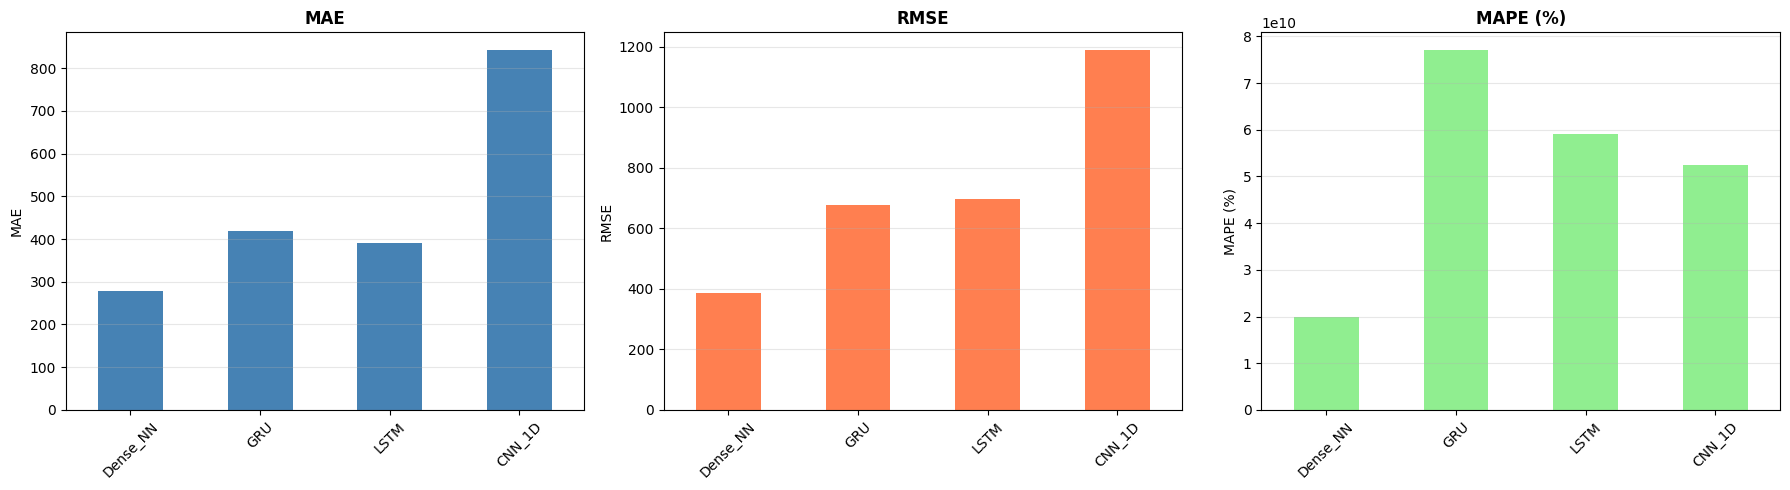

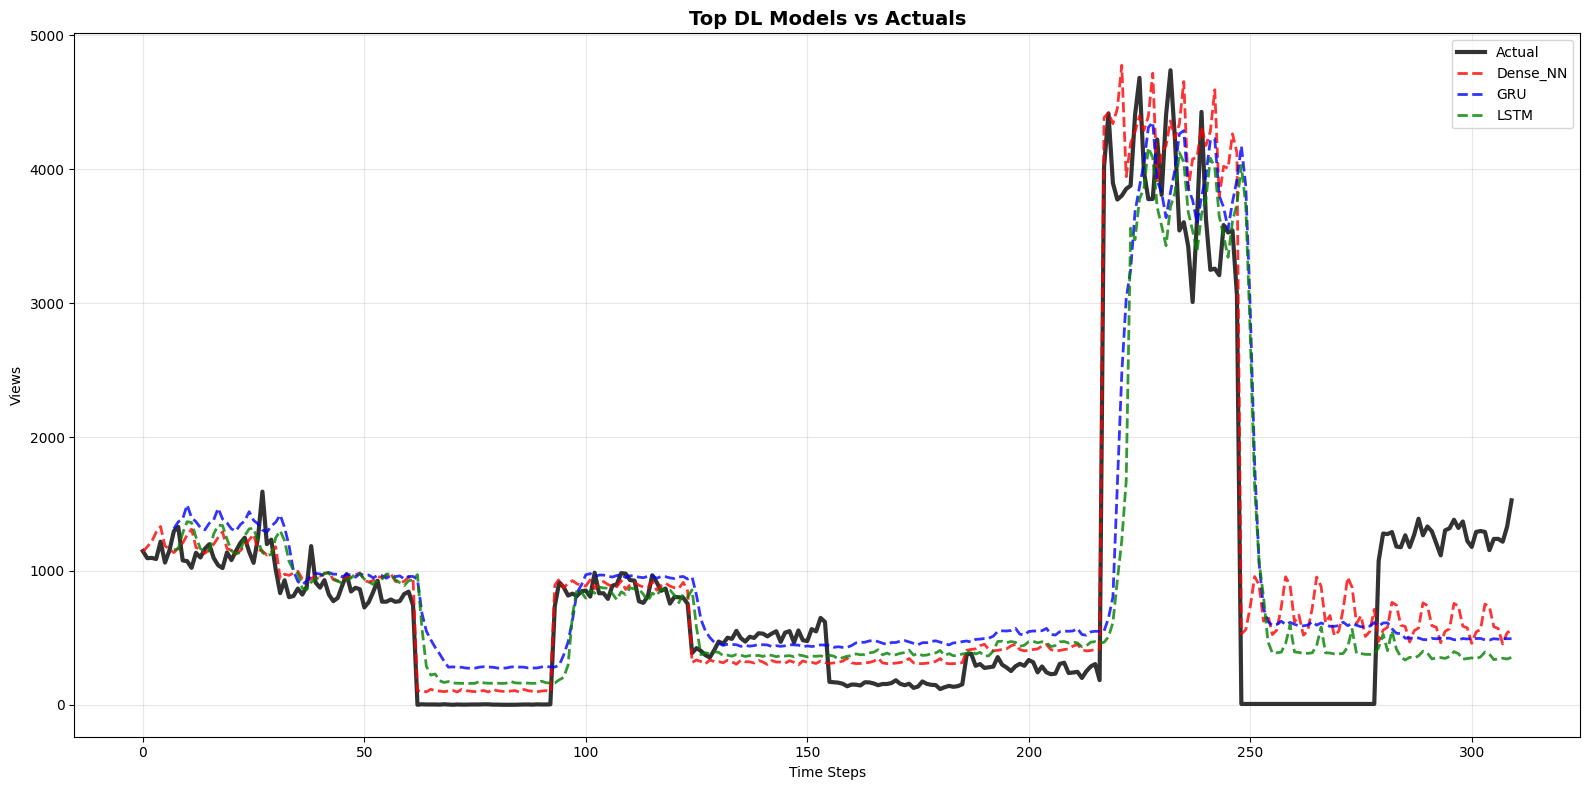

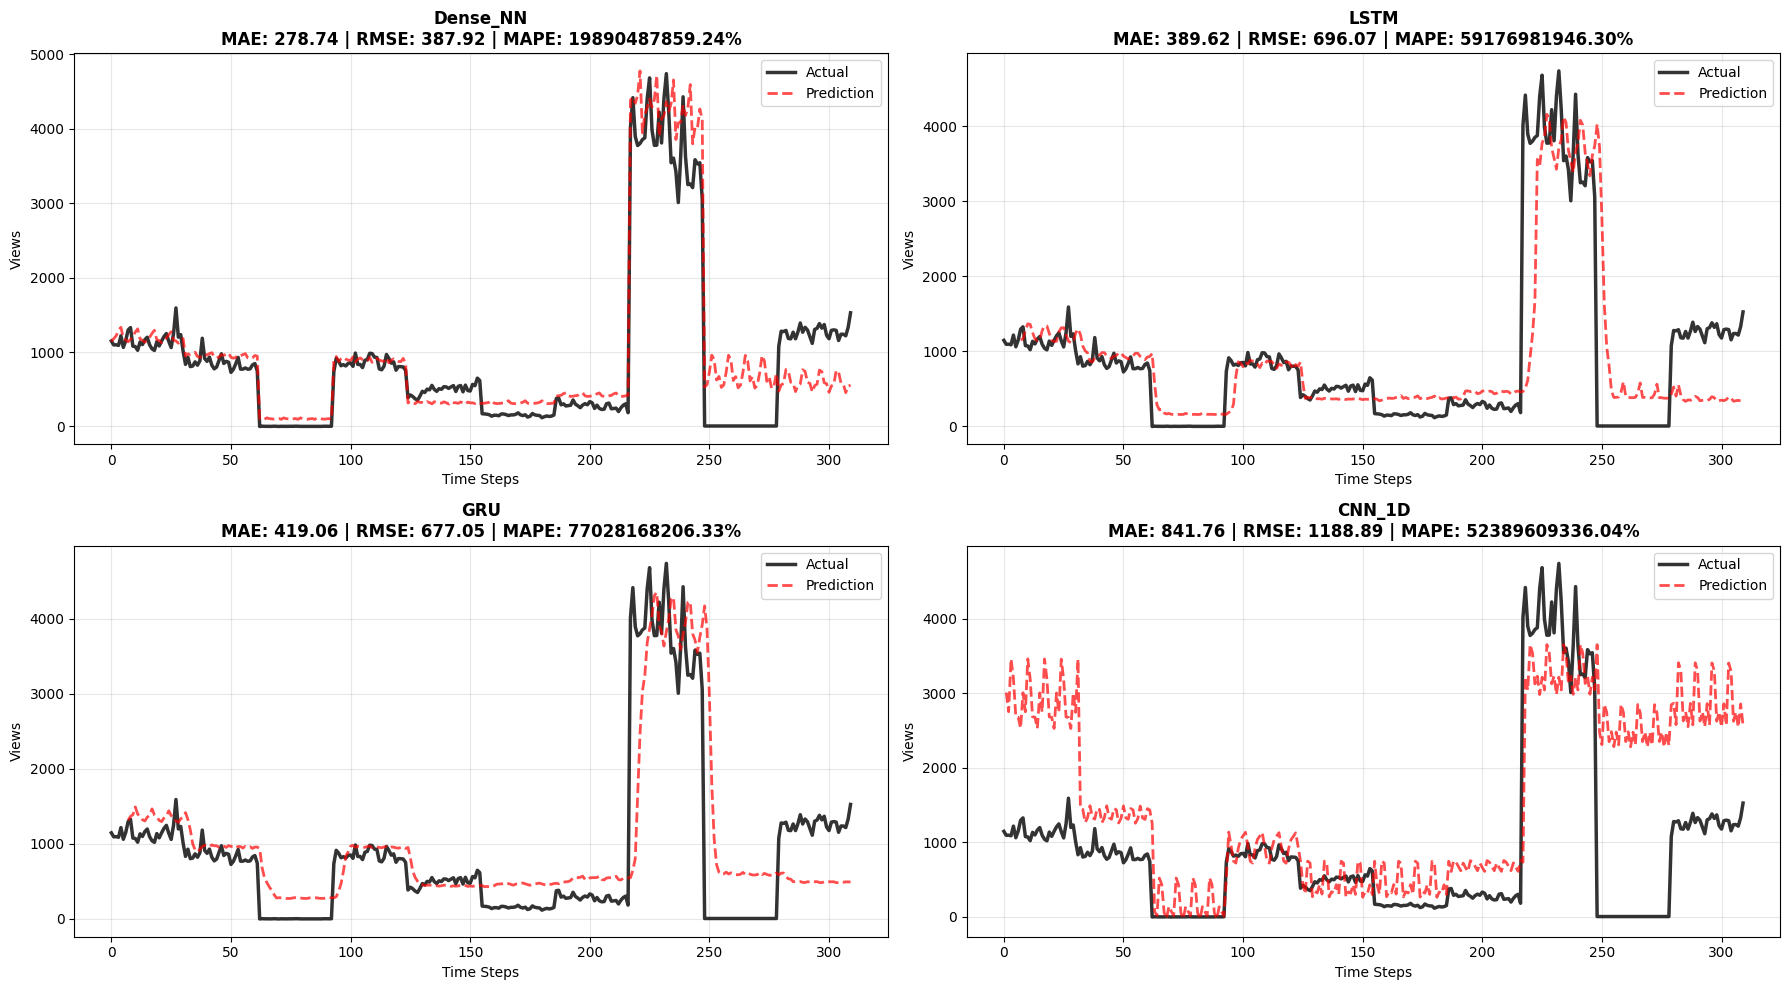

In [ ]:
# Fourier
features_f = get_features(fourier_train)
fourier = scale_data(fourier_train, fourier_test, target_col = "y", feature_cols=features_f)
fourier_results = train_dl_models(fourier[2], fourier[0], fourier[3], fourier[5], fourier[4])
comp_df = model_comparison(fourier_results[0])
top_models(comp_df, fourier_results[1], fourier[5])
individual_model_performance(fourier_results[1], fourier[5], fourier_results[0])

c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\kera


DEEP LEARNING MODEL COMPARISON (lower is better):
                 MAE         RMSE                MAPE
Dense_NN  342.467774   510.009241  22819216717.933838
LSTM      394.321083   640.914659  66771701644.895958
GRU       394.150173   662.868609  77928038070.298767
CNN_1D    907.505032  1247.328376  79234460540.368576


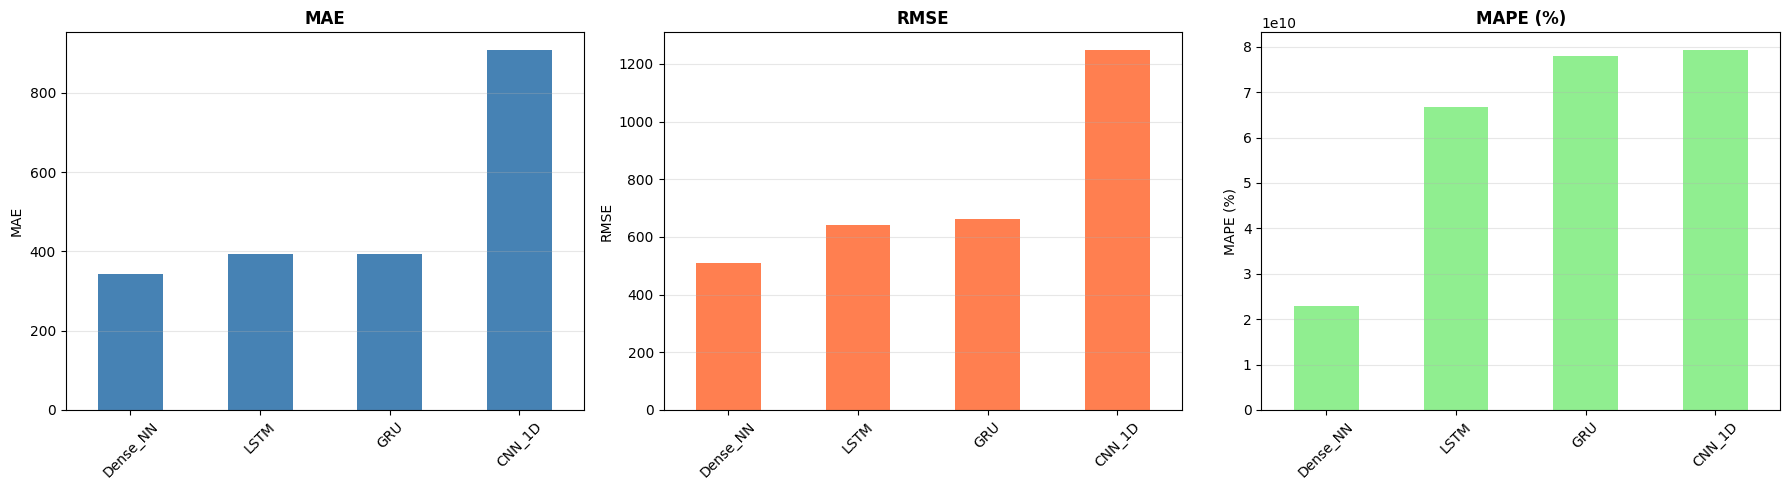

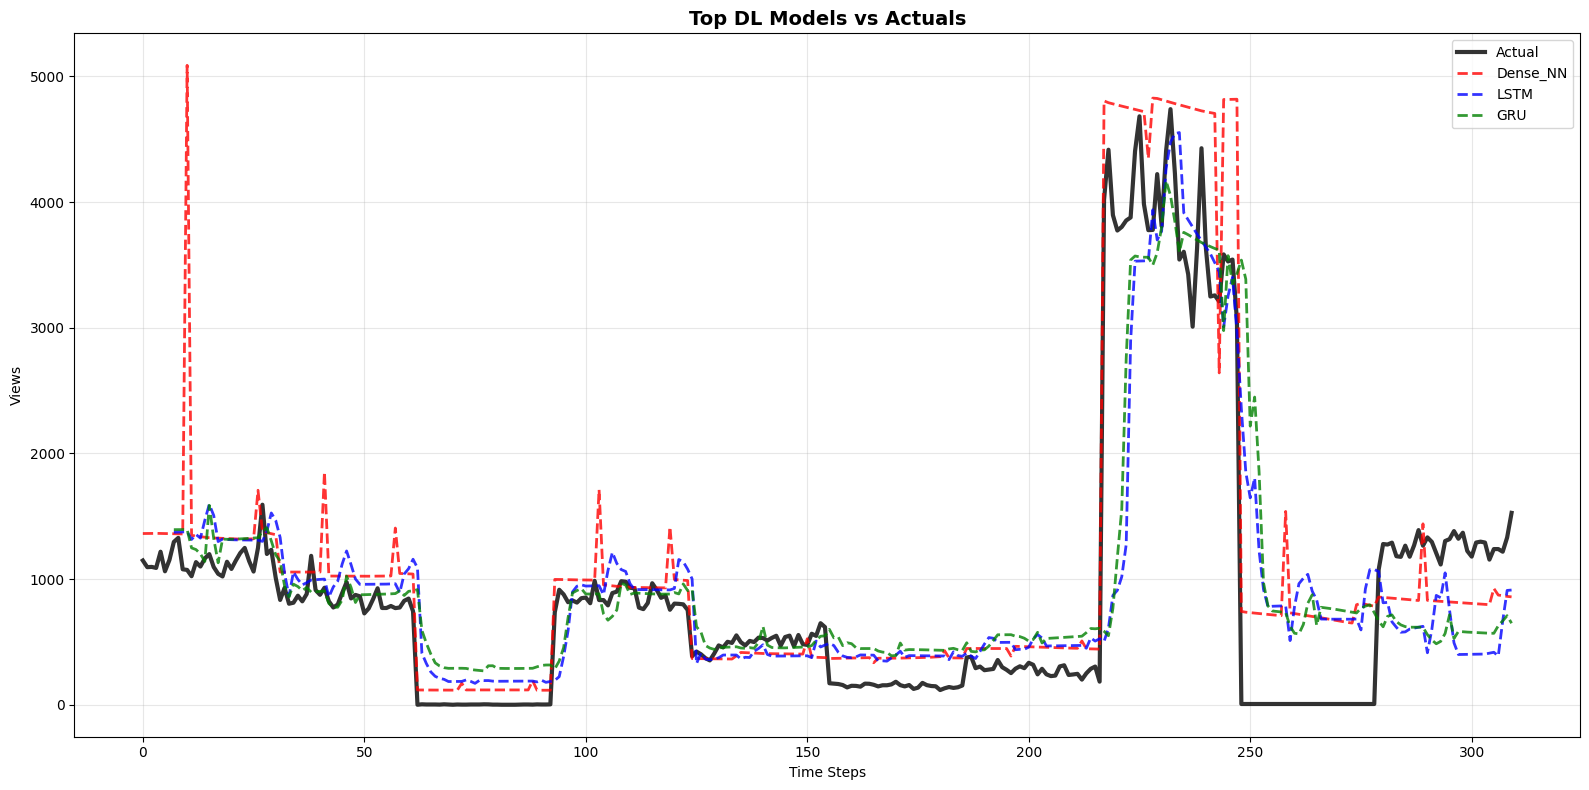

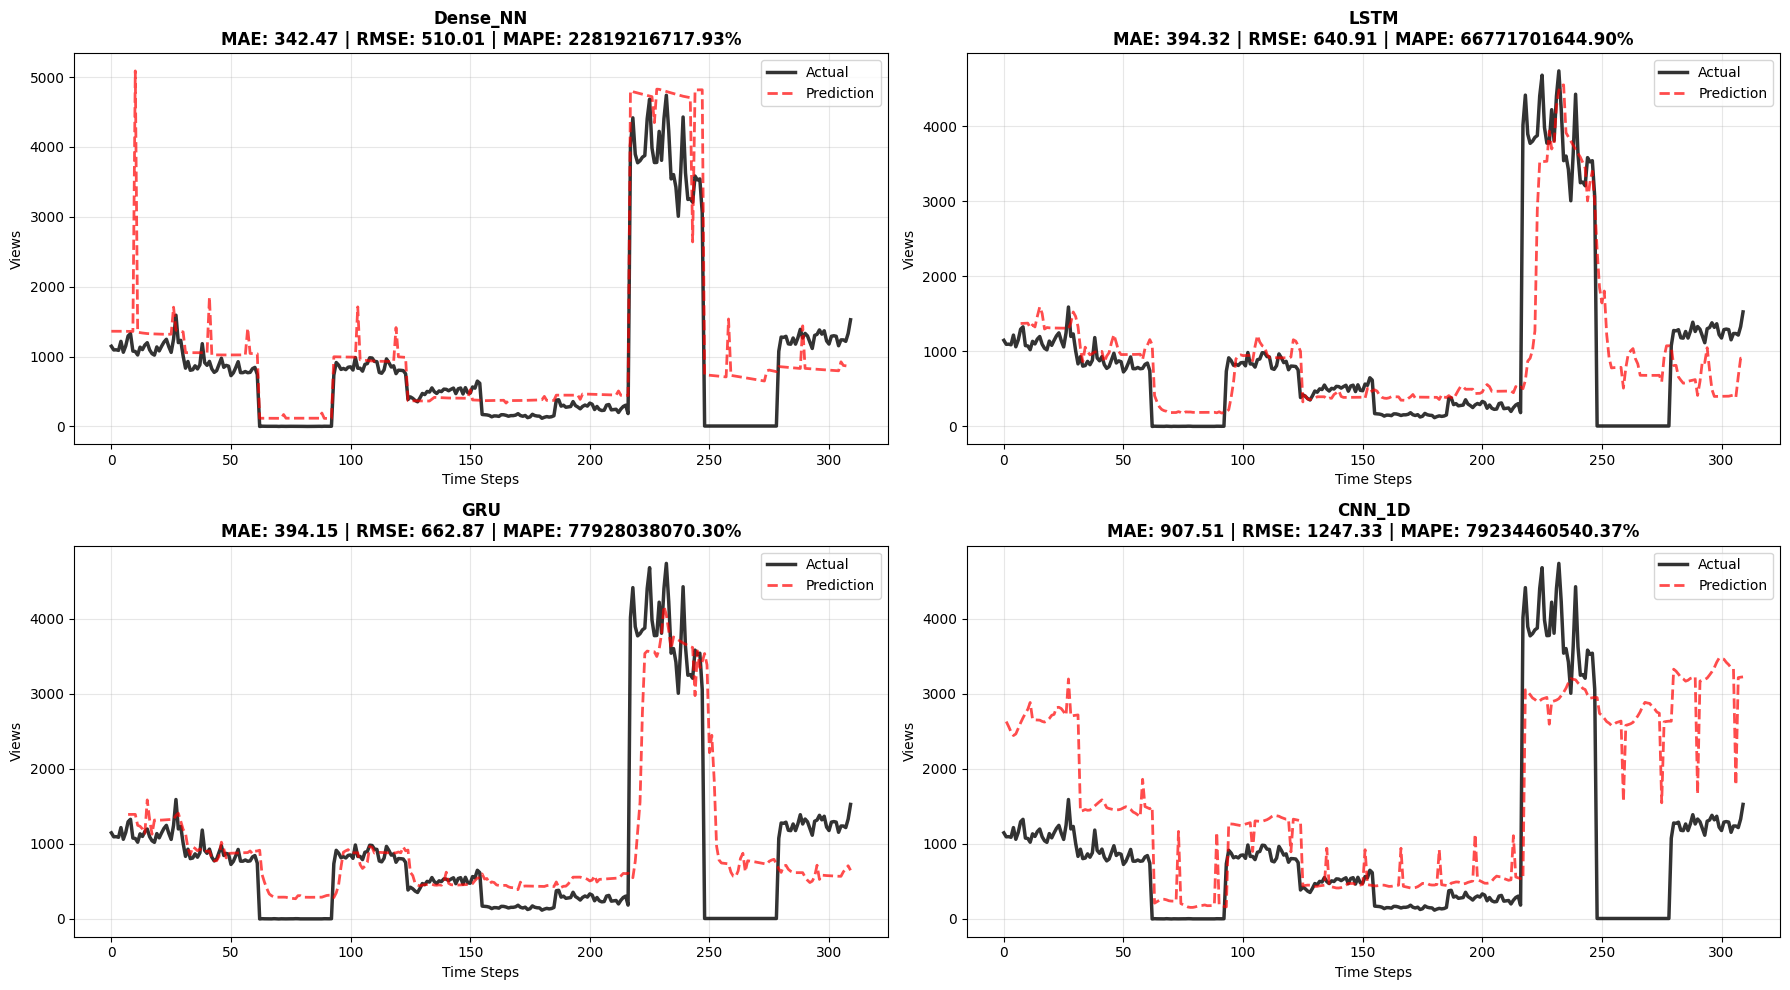

In [ ]:
# Holidays
features_h = get_features(holidays_train)
holidays= scale_data(holidays_train, holidays_test, target_col = "y", feature_cols=features_h)
holidays_results = train_dl_models(holidays[2], holidays[0], holidays[3], holidays[5], holidays[4])
comp_df = model_comparison(holidays_results[0])
top_models(comp_df, holidays_results[1], holidays[5])
individual_model_performance(holidays_results[1], holidays[5], holidays_results[0])

c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\kera


DEEP LEARNING MODEL COMPARISON (lower is better):
                 MAE         RMSE                 MAPE
CNN_1D    614.683154   929.114655  171783533195.723785
GRU       743.011321   999.959152  109797924769.595001
Dense_NN  767.384443  1068.069511   14795863611.722555
LSTM      786.180579  1142.174102    88749795777.09964


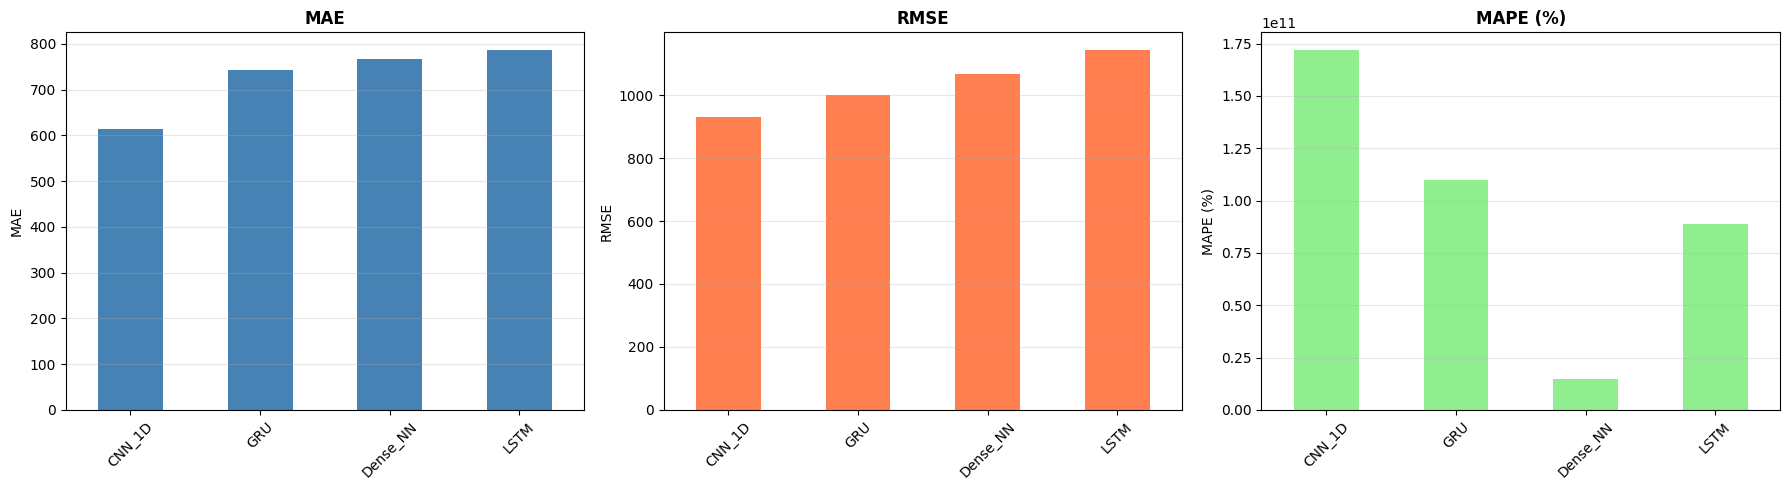

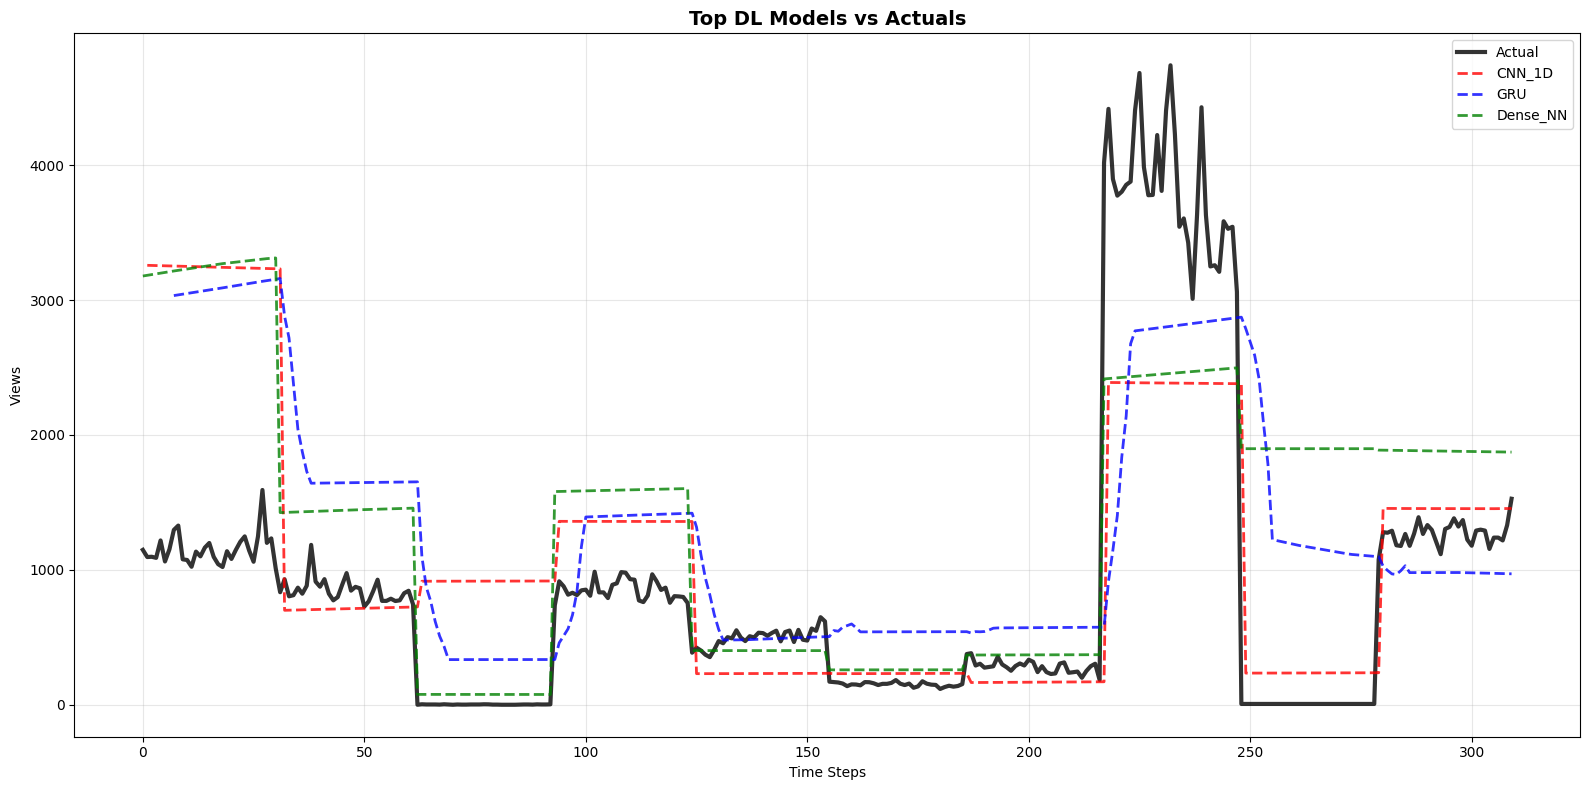

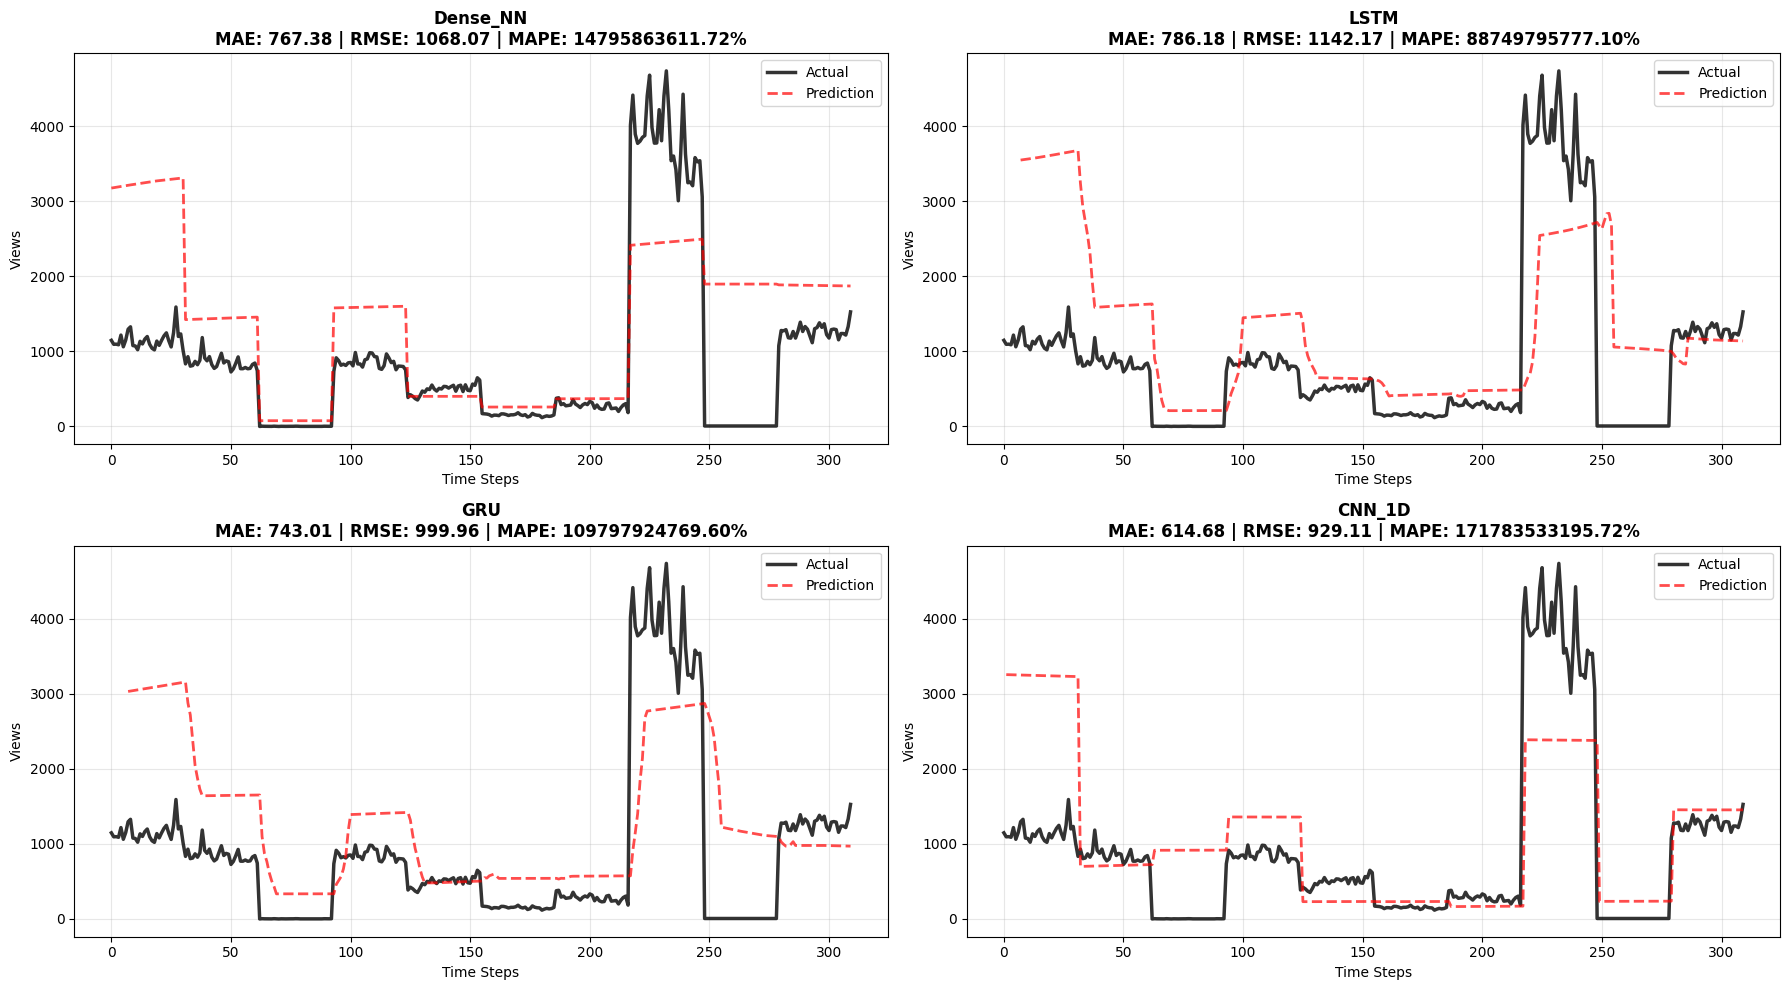

In [ ]:
# Trends
features_t = get_features(trend_train)
trends = scale_data(trend_train, trend_test, target_col = "y", feature_cols=features_t)
trends_results = train_dl_models(trends[2], trends[0], trends[3], trends[5], trends[4])
comp_df = model_comparison(trends_results[0])
top_models(comp_df, trends_results[1], trends[5])
individual_model_performance(trends_results[1], trends[5], trends_results[0])

c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\kera


DEEP LEARNING MODEL COMPARISON (lower is better):
                  MAE         RMSE                 MAPE
CNN_1D     675.033848   924.101482   50007382851.978455
Dense_NN   929.075634  1309.836135   31073261784.183235
LSTM       980.625154   1335.49393   87105786246.909714
GRU       1095.660657  1381.448897  112904674535.691254


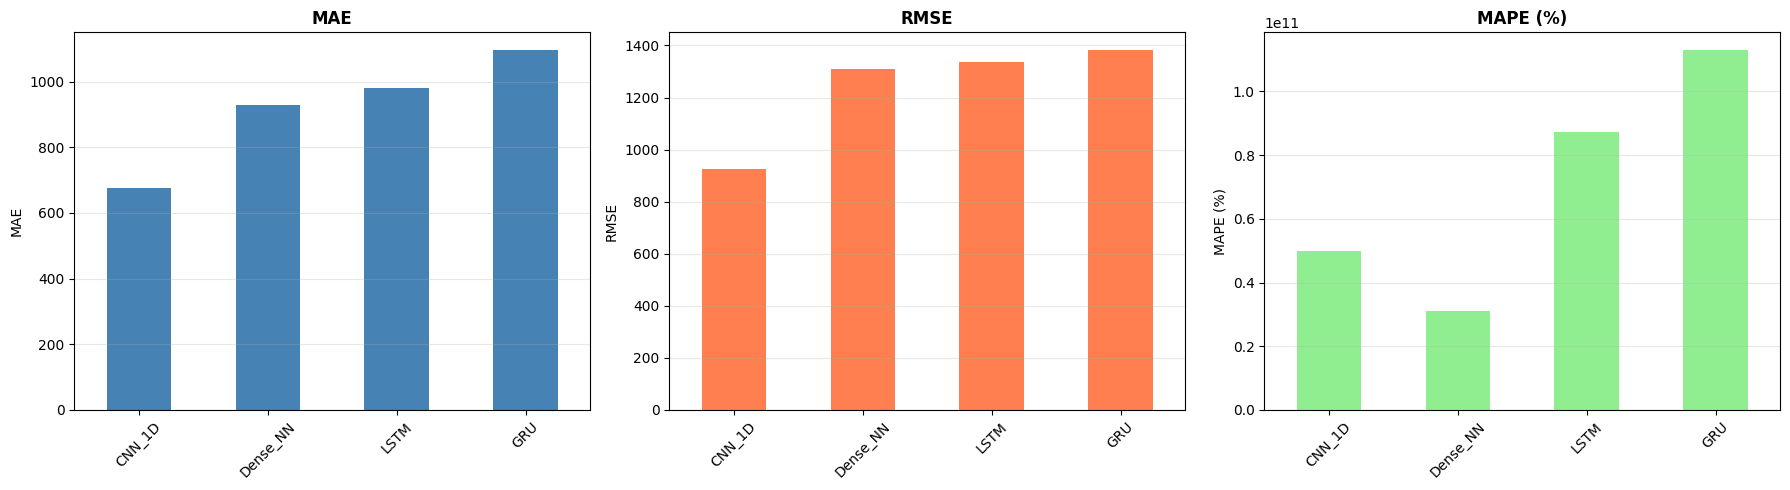

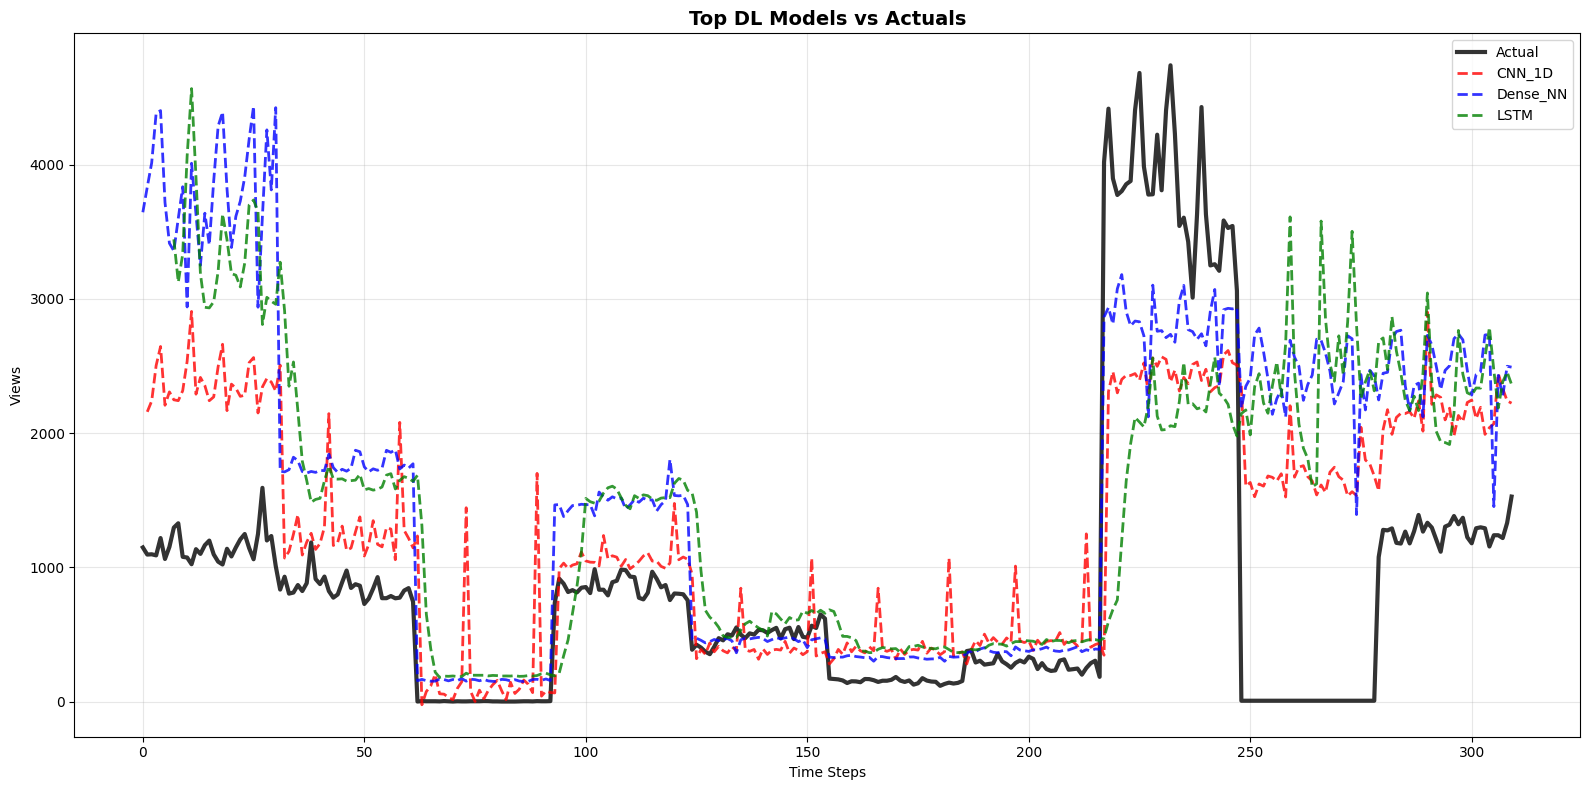

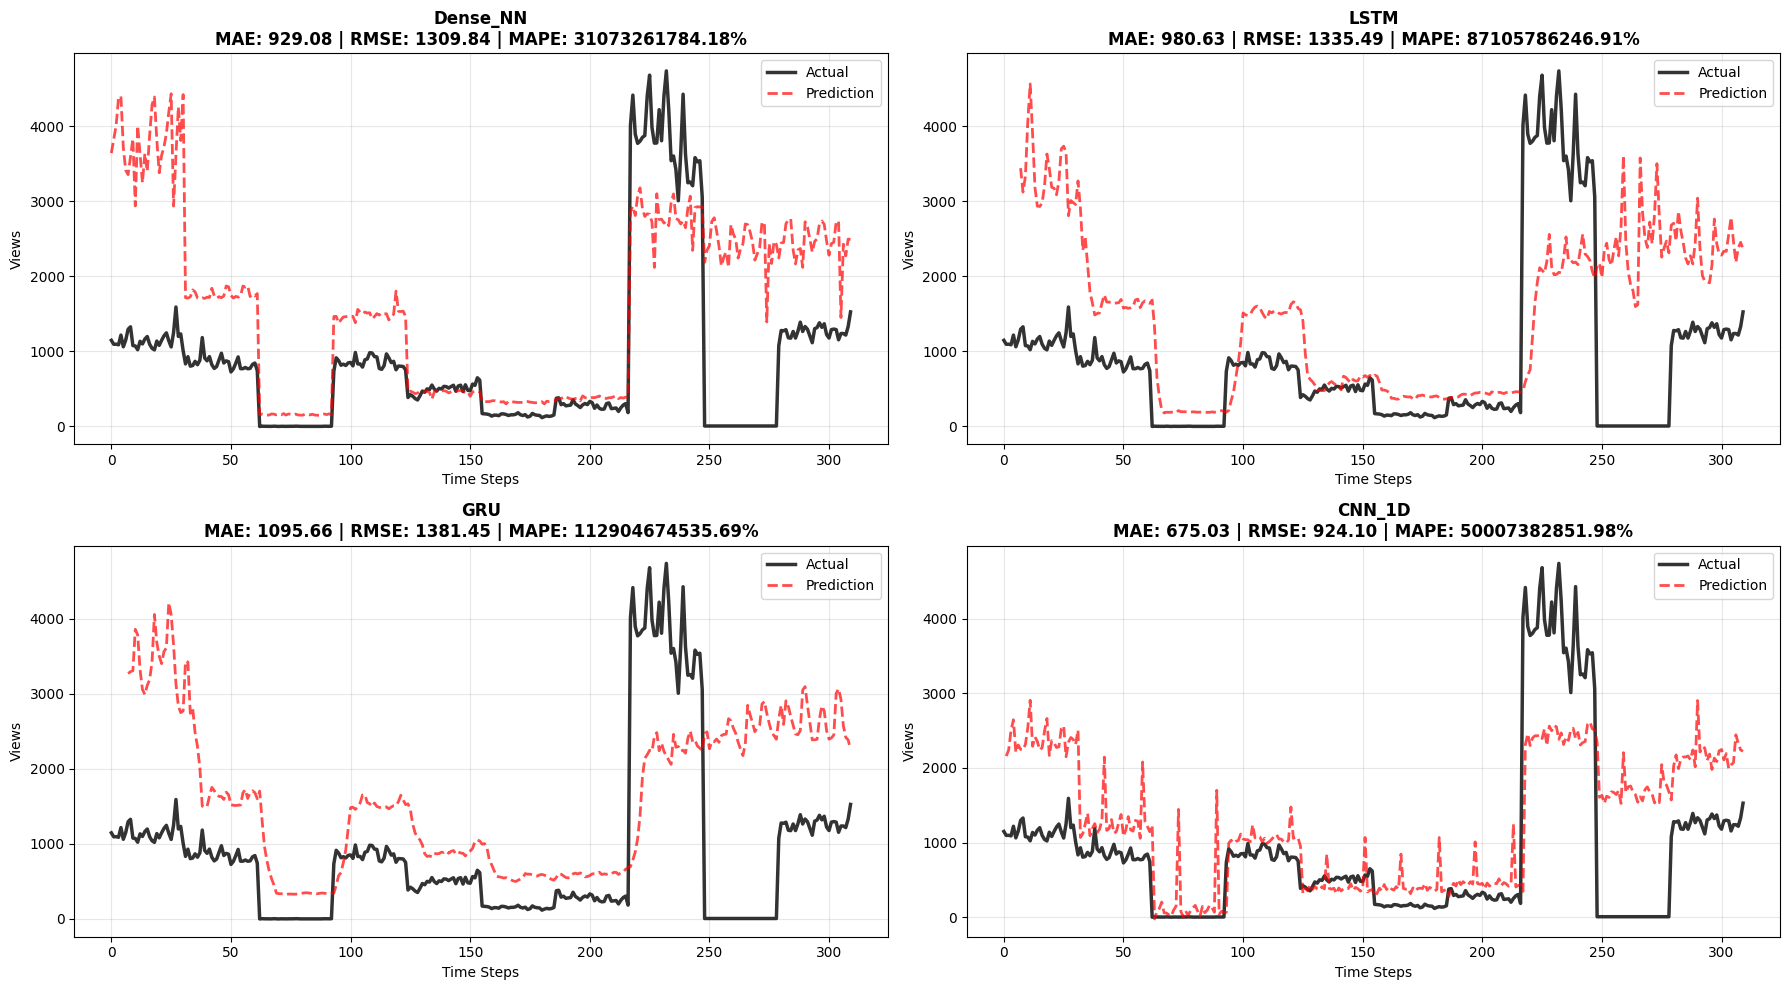

In [ ]:
# Fourier + Holidays + Trends
features_fth = get_features(fth_train)
fth = scale_data(fth_train, fth_test, target_col = "y", feature_cols=features_fth)
fth_results = train_dl_models(fth[2], fth[0], fth[3], fth[5], fth[4])
comp_df = model_comparison(fth_results[0])
top_models(comp_df, fth_results[1], fth[5])
individual_model_performance(fth_results[1], fth[5], fth_results[0])